# Examen d'ocvx 2

## Section 1

### Question 1

In [2]:
import warnings
import math
import time
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class test_function():
    """Objet Test Function.
    
    Représente un problème d'optimisation.
    """  
    
    def __init__(self, name, value, dim, nb_params, convex=None, grad=None, hess=None, HCN=None, constraints = None):
        """ 
        Instancie un objet Test Function.

        Attributes:
        name: nom de la fonction.
        value: valeur de la fonction.
        dim: nombre de dimensions.
        nb_params: nombre de parametres que prend la fonction.
        convex: la fonction est convexe (True) ou pas (False).
        grad: gradient de la fonction.
        hess: hessienne de la fonction.
        """
        self.name = name
        self.value = value
        self.dim = dim
        self.nb_params = nb_params
        self.convex = convex
        self.grad = grad
        self.hess = hess

In [4]:
# fonction convexe à une dimension admettant un minimum en x=-0.5, y=0.75

mini_1_d = {
    "name": "mini_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x: np.square([x])+x+1),
    "grad"  : (lambda x: np.array([2*x + 1])),
    "hess"  : (lambda x: np.array([2]))
}

mini_1 = test_function(**mini_1_d)

In [5]:
# fonction concave à une dimension admettant un maximum en x=1, y=2

maxi_1_d = {
    "name": "maxi_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x: -1*np.square([x])+2*x+1),
    "grad"  : (lambda x: np.array([-2*x + 2])),
    "hess"  : (lambda x: np.array([-2]))
}

maxi_1 = test_function(**maxi_1_d)

In [6]:
exp_1_d = {
    "name": "exp_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x: np.array([np.exp(x)+np.exp(-x)-1])),
    "grad"  : (lambda x: np.array([np.exp(x)-np.exp(-x)])),
    "hess"  : (lambda x: np.array([np.exp(-x)+np.exp(x)]))
}

exp_1 = test_function(**exp_1_d)

In [7]:
cubic_1_d = { 
    "name": "cubic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False,
    "value" : (lambda x: np.array([np.power(x,3) + 3*np.square(x) + x + 1])),
    "grad"  : (lambda x: np.array([3*np.square(x) + 6*x + 1])),
    "hess"  : (lambda x: np.array([6*x + 6]))
}

cubic_1 = test_function(**cubic_1_d)

In [8]:
# fonction quadratique à deux dimensions centrée en x=0, y=0

func_3_d = {
    "name": "quad_2",
    "dim" : 2,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x: x[:, 0]**2 + 10*x[:, 1]**2),
    "grad"  : (lambda x: np.array([[2*x[:, 0]], [20*x[:, 1]]]).reshape(1, -1)),
    "hess"  : (lambda x: np.diag([2, 20]))
}

func_3 = test_function(**func_3_d)

### Question 2

In [9]:
def hess_inverse(f, x):
    """Calcule l'inverse de la hessienne.
    
    Args:
        f: fonction objectif.
        x: point auquel l'inverse de la hessienne est calculé.
        
    Output:
        (ndarray)

    """

    if (len(f.hess(x).shape) == 1):
        return 1/f.hess(x)
    return np.linalg.inv(f.hess(x))

In [10]:
def get_direction(f, x, hess_inv):
    """Choisit la direction (minimisant de la fonction).
    
    Args:
        f: fonction objectif.
        x: point auquel la direction est choisie.
        hess_inv: inverse de la hessienne.
        
    Output:
        (ndarray)

    """
    
    if f.dim == 1:
        return -1*hess_inv*f.grad(x)
    return (-1*hess_inv@(f.grad(x).T)).T

In [11]:
# estimation de lambda carré (écart entre le minimisant de l'approximation
# du second ordre de f et la valeur de f)

def get_lambda(f, x, x_dir):
    """Estime lambda carré (écart entre le minimisant de l'approximation
    du second ordre de f et la valeur de f)
    
    Args:
        f: fonction objectif.
        x: point auquel lambda est calculé.
        x_dir: direction.
        
    Output:
        (ndarray)

    """

    if f.dim == 1:
        return abs(-1*np.transpose(f.grad(x))*x_dir)
    return abs(-1*(f.grad(x).T)@x_dir)

In [12]:
def found(f, l, epsilon):
    """Vérifie si la condition d’arrêt traditionnelle
    de la méthode de Newton est remplie
    
    Args:
        f: fonction objectif.
        l: lambda.
        x_dir: direction.
        
    Output:
        (bool)

    """
    
    if f.dim == 1:
        return abs(l/2) <= epsilon
    return abs(l/2).any() <= epsilon

In [13]:
def newton(f, x, epsilon=0.0001):
    """Implémente la méthode de Newton visant à calculer un
    point optimal d'une fonction convexe.
    
    Args:
        f: fonction objectif.
        x: point initial appartenant au domaine de f.
        epsilon: tolérance.
        
    Output:
        (ndarray) point optimal.
        (ndarray) valeur optimale.
        (int) nombre d'itérations.

    """
    
    hess_inv = hess_inverse(f, x)
    
    x_dir = get_direction(f, x, hess_inv)
    # lambda pour la condition d'arret
    l = get_lambda(f, x, x_dir)
    
    n_iter = 0
    
    while not found(f, l, epsilon):
        
        # mise à jour des valeurs en fonction du nouveau x
        x_dir = get_direction(f, x, hess_inv)
        l = get_lambda(f, x, x_dir)

        # mise à jour de x
        x = x+x_dir
        n_iter += 1
    
    ob_val = f.value(x)
    
    return x.flatten(), ob_val.flatten(), n_iter

In [14]:
start = time.time()
newton_op_pt, newton_ob_val, newton_n_iter = newton(maxi_1, np.array(3))
print("Temps d'execution : %s secondes" % (time.time() - start))
print("Estimation : ", newton_op_pt)
print("Ob value : ", newton_ob_val)
print("Nombre d'iterations : ", newton_n_iter)

Temps d'execution : 0.0007138252258300781 secondes
Estimation :  [1.]
Ob value :  [2.]
Nombre d'iterations :  2


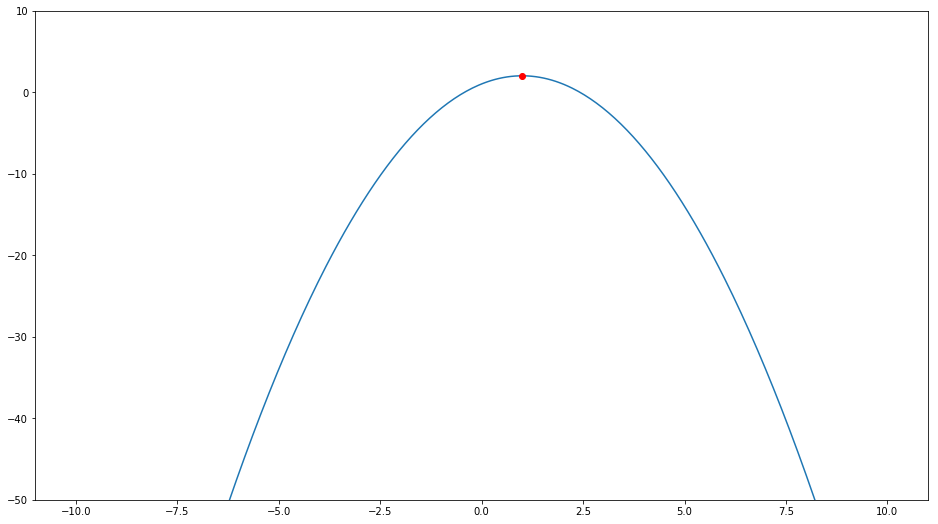

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 10)
ax.plot(x, maxi_1.value(x).flatten())
ax.plot([newton_op_pt], [newton_ob_val], 'ro')

In [16]:
start = time.time()
newton_op_pt, newton_ob_val, newton_n_iter = newton(mini_1, np.array(3))
print("Temps d'execution : %s secondes" % (time.time() - start))
print("Estimation : ", newton_op_pt)
print("Ob value : ", newton_ob_val)
print("Nombre d'iterations : ", newton_n_iter)

Temps d'execution : 0.0008208751678466797 secondes
Estimation :  [-0.5]
Ob value :  [0.75]
Nombre d'iterations :  2


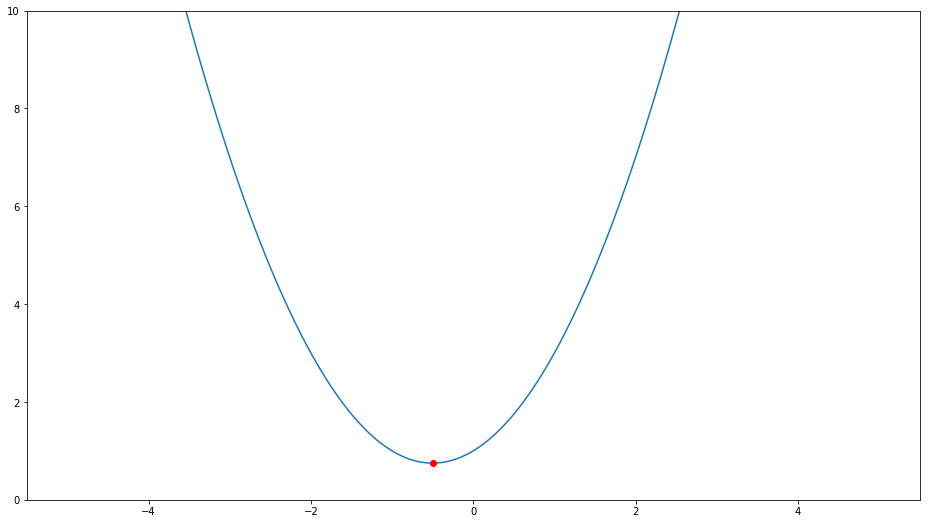

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-5, 5, 400)
ax.set_ylim(0, 10)
ax.plot(x, mini_1.value(x).flatten())
ax.plot([newton_op_pt], [newton_ob_val], 'ro')

In [18]:
start = time.time()
newton_op_pt, newton_ob_val, newton_n_iter = newton(exp_1, np.array([3]))
print("Temps d'execution : %s secondes" % (time.time() - start))
print("Estimation : ", newton_op_pt)
print("Ob value : ", newton_ob_val)
print("Nombre d'iterations : ", newton_n_iter)

Temps d'execution : 0.00483393669128418 secondes
Estimation :  [0.02719736]
Ob value :  [1.00073974]
Nombre d'iterations :  39


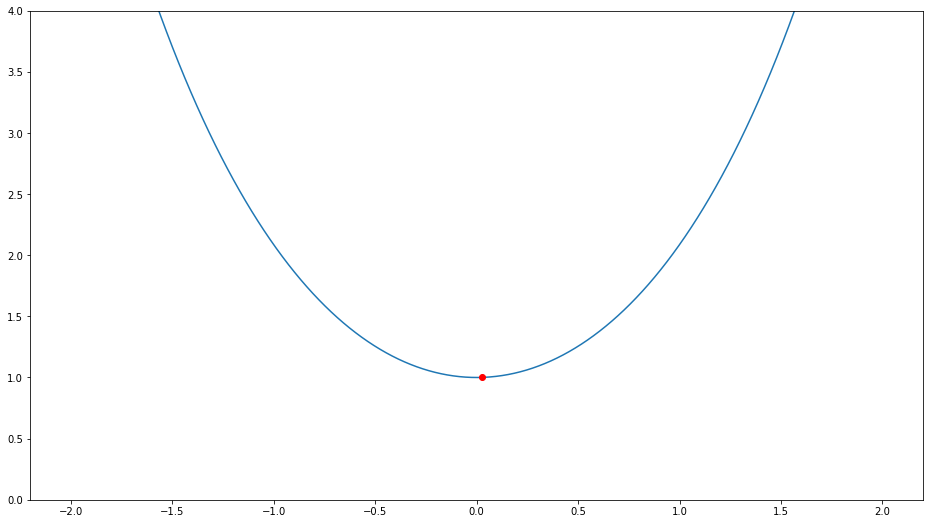

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-2, 2, 400)
ax.set_ylim(0, 4)
ax.plot(x, exp_1.value(x).flatten())
ax.plot([newton_op_pt], [newton_ob_val], 'ro')

In [20]:
start = time.time()
newton_op_pt, newton_ob_val, newton_n_iter = newton(cubic_1, np.array([3]))
print("Temps d'execution : %s secondes" % (time.time() - start))
print("Estimation : ", newton_op_pt)
print("Ob value : ", newton_ob_val)
print("Nombre d'iterations : ", newton_n_iter)

Temps d'execution : 0.002685070037841797 secondes
Estimation :  [-0.17341095]
Ob value :  [0.91158842]
Nombre d'iterations :  19


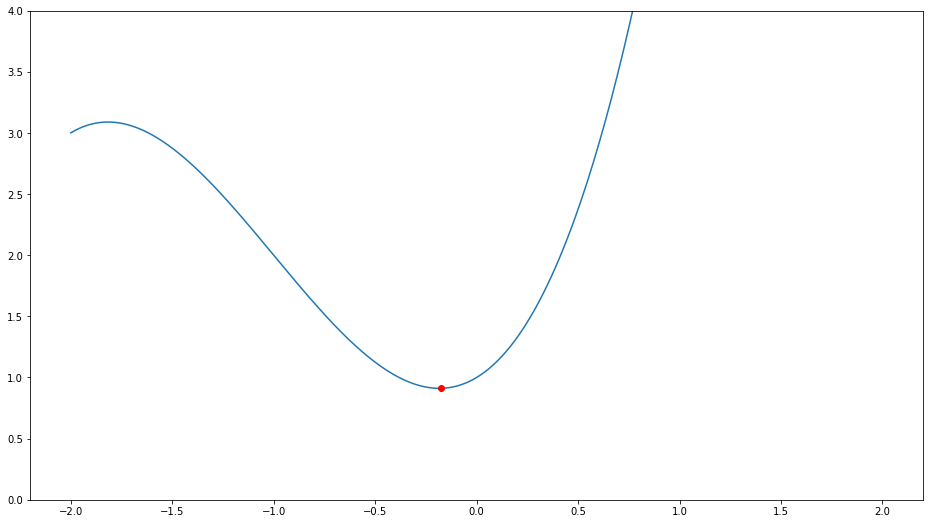

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-2, 2, 400)
ax.set_ylim(0, 4)
ax.plot(x, cubic_1.value(x).flatten())
ax.plot([newton_op_pt], [newton_ob_val], 'ro')

In [22]:
start = time.time()
newton_op_pt, newton_ob_val, newton_n_iter = newton(func_3, np.array([[3,3]]))
print("Temps d'execution : %s secondes" % (time.time() - start))
print("Estimation : ", newton_op_pt)
print("Ob value : ", newton_ob_val)
print("Nombre d'iterations : ", newton_n_iter)

Temps d'execution : 0.002256155014038086 secondes
Estimation :  [0. 0.]
Ob value :  [0.]
Nombre d'iterations :  2


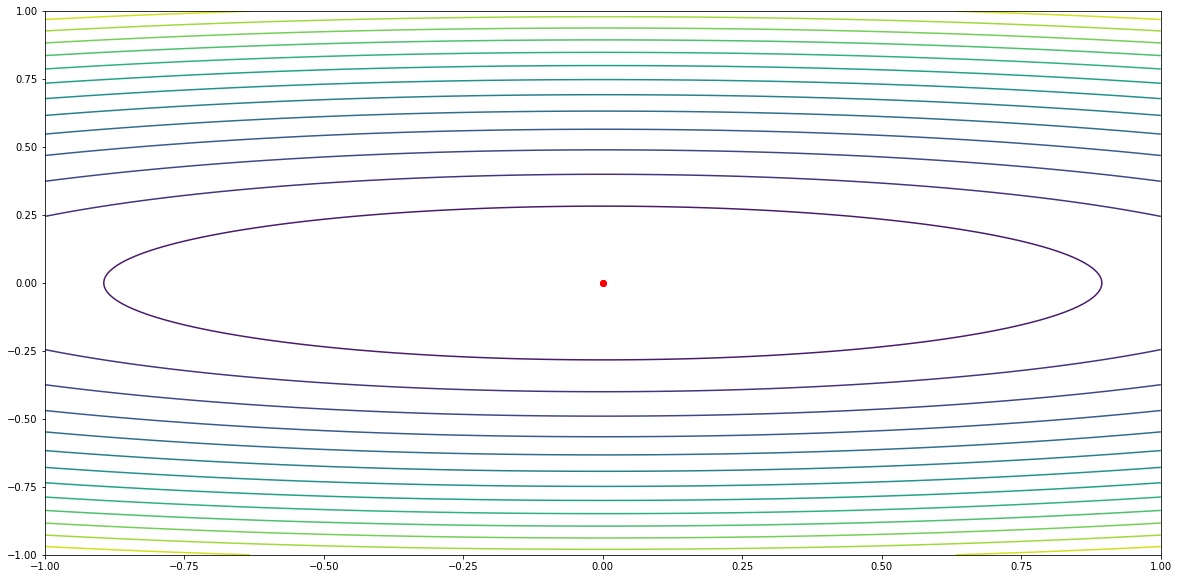

In [23]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -1, 1, -1, 1
fig, ax = plt.subplots(figsize=(20, 10))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
ax.set_xlim(x_mi, x_ma)
ax.set_ylim(y_mi, y_ma)
ax.contour(X, Y, func_3.value(x_y).reshape(nb_pts, -1), 15)
ax.plot([newton_op_pt], [newton_ob_val], 'ro')

### Question 3

In [24]:
# implémentation de descente de gradient vue en TP

def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [25]:
# foncntions données en TP

quad_I_d = {
    "name": "mini_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x, gamma: gamma*(x**2) + x + 1),
    "grad"  : (lambda x, gamma: 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 2*gamma),
    "HCN"   : 1
}

quad_I = test_function(**quad_I_d)

quad_II_d = {
    "name": "quad_2",
    "dim" : 2,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: x[:, 0]**2 + gamma*x[:, 1]**2),
    "grad"  : (lambda x, gamma: np.array([2*x[:, 0], 2*gamma*x[:, 1]]).reshape(1, -1)),
    "hess"  : (lambda x, gamma: np.diag([2, 2*gamma])),
    "HCN"   : (lambda x, gamma: gamma)
}

quad_II = test_function(**quad_II_d)

cubic_I_d = { 
    "name": "cubic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False,
    "value" : (lambda x, gamma: x**3 + gamma*x**2 + x + 1),
    "grad"  : (lambda x, gamma: 3*x**2 + 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 6*x + 2*gamma),
    "HCN"   : 1
}

cubic_I = test_function(**cubic_I_d)

In [43]:
# implémentation de descente de gradient vue en TP

class GD(object):
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        return (x, iters, iters_dir, n_iter) 

In [63]:
class backtracking():
    
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        
    def __call__(self, x, f, dir_x, grad, n_iter, eta, tol=1e-6):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = grad(x, f, tol)
        while f(x + t * dir_x) > f(x) + self.alpha * t * grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta * t
            n_while += 1
        return t

bt_rate = backtracking()
gammas = np.linspace(1, 10, 10)
cst_rates = np.linspace(0.01, 0.5, 200)

def dsgd(x, f, grad, tol):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    grad_f = grad(x, f, tol)
    abs_grad = np.abs(grad_f)
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = grad_f[0, imax_diff]
    return (- sdescent)

In [46]:
test_list_Newton = [mini_1, cubic_1, func_3]
test_list_GD = [quad_I, cubic_I, quad_II]
gammas = [1, 3, 1]
x_inits = [np.array([10]), np.array([10]), np.array([[2, 2]])]

In [47]:
import pandas as pd

In [65]:
# tableau de comparaison entre methode de Newton et celles de GD

test_summary = pd.DataFrame(columns=["method", "temps_exec", "estimation", "ob_value", "nb_iter"])

for i in range(len(test_list_Newton)):

    idt = 0
    
    init_x = x_inits[i]
    gamma = gammas[i]
    
    GD_default = GD()
    start = time.time()
    gd_op_pt, iters, iters_dir, gd_n_iter = GD_default(init_x, (lambda x : test_list_GD[i].value (x, gamma)), 
                                             (lambda x, f, tol : test_list_GD[i].grad (x, gamma)), True)
    end = time.time() - start
    naming_format = "{}_{}".format(test_list_GD[i].name, idt)
    test_summary.loc[naming_format] = pd.Series({"method": "GD pas constant",
                                                 "temps_exec": end, 
                                                 "estimation": gd_op_pt.flatten(),
                                                 "ob_value": test_list_GD[i].value(gd_op_pt, gamma).flatten(),
                                                 "nb_iter": gd_n_iter})
    
    idt += 1
    
    GD_test = GD(rate = bt_rate)
    start = time.time()
    gd_op_pt, iters, iters_dir, gd_n_iter = GD_test(init_x, 
                                             (lambda x: test_list_GD[i].value(x, gamma)), 
                                             (lambda x, f, tol : test_list_GD[i].grad(x, gamma)))
    
    end = time.time() - start
    naming_format = "{}_{}".format(test_list_GD[i].name, idt)
    test_summary.loc[naming_format] = pd.Series({"method": "GD backtracking",
                                                 "temps_exec": end, 
                                                 "estimation": gd_op_pt.flatten(),
                                                 "ob_value": test_list_GD[i].value(gd_op_pt, gamma).flatten(),
                                                 "nb_iter": gd_n_iter})
    
    idt += 1
    
    GD_test = GD(ddir = dsgd, rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.1)
    start = time.time()
    gd_op_pt, iters, iters_dir, gd_n_iter = GD_test(init_x, 
                                             (lambda x: test_list_GD[i].value(x, gamma)), 
                                             (lambda x, f, tol : test_list_GD[i].grad(x, gamma)))
    
    end = time.time() - start
    naming_format = "{}_{}".format(test_list_GD[i].name, idt)
    test_summary.loc[naming_format] = pd.Series({"method": "GD l1",
                                                 "temps_exec": end, 
                                                 "estimation": gd_op_pt.flatten(),
                                                 "ob_value": test_list_GD[i].value(gd_op_pt, gamma).flatten(),
                                                 "nb_iter": gd_n_iter})
    
    idt += 1
    
    start = time.time()
    newton_op_pt, newton_ob_val, newton_n_iter = newton(test_list_Newton[i], init_x)
    end = time.time() - start
    naming_format = "{}_{}".format(test_list_Newton[i].name, idt)
    test_summary.loc[naming_format] = pd.Series({"method": "Newton",
                                                 "temps_exec": end, 
                                                 "estimation": newton_op_pt,
                                                 "ob_value": newton_ob_val,
                                                 "nb_iter": newton_n_iter})
    
    idt += 1
    
test_summary

/Users/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in power
/Users/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in square
/Users/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in add
/Users/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/Users/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add


,method,temps_exec,estimation,ob_value,nb_iter
mini_1_0,GD pas constant,0.092208,[-0.49999950459258535],[0.7500000000002454],835
mini_1_1,GD backtracking,0.007869,[-0.49999969916261006],[0.7500000000000905],34
mini_1_2,GD l1,0.010723,[-0.49999954707289596],[0.7500000000002052],76
mini_1_3,Newton,0.000404,[-0.5],[0.75],2
cubic_1_0,GD pas constant,0.085468,[-0.33333283357071136],[0.8518518518521017],692
cubic_1_1,GD backtracking,0.002857,[-inf],[nan],8
cubic_1_2,GD l1,0.002200,[-inf],[nan],10
cubic_1_3,Newton,0.007432,[-0.16365897720764955],[0.9123103205231412],53
quad_2_0,GD pas constant,0.095768,"[4.946123910360939e-07, 1.1649405325821872e-20]",[2.446414173664419e-13],753
quad_2_1,GD backtracking,0.176115,"[2.985364752673896e-219, -1.6301298532334858e-07]",[7.971970015209078e-14],473


### Question 8

Souvent, la hessienne nous est inconnue. Dans ce cas, on ne peut pas utiliser la méthode de Newton.

Une méthode de Quasi-Newton suit les memes étapes que celle de Newton, mais au
lieu d'utiliser la hessienne on va utiliser son approximation.

Afin d'approximer la hessienne, la méthode la plus utilisée est celle de Broyden, dans laquelle la matrice d'approximation B s'écrit :

$$ B_{k+1}=B_k+\frac{s_k-B_{k} y_k}{^ts_k\, B_{k}y_k} (^ts_k B_{k}) $$

avec $$ s_k = x_{k+1} – x_k, y_k = f (x_{k+1}) – f (x_k).$$